In [1]:
%pylab inline
import numpy as np
import pandas as pd
from pymongo import MongoClient
from tqdm import tqdm
import hashlib
import pickle
import cv2

import config

Populating the interactive namespace from numpy and matplotlib


In [10]:
def _img_from_bytes(img_bytes):
    np_img_str = np.fromstring(img_bytes, np.uint8)
    img = cv2.imdecode(np_img_str, cv2.IMREAD_COLOR)
    assert img is not None
    return img

In [11]:
def get_md5(img):
    return hashlib.md5(img).hexdigest()

In [28]:
train = dict()
counts = dict()
unique = dict()

client = MongoClient(connect=False)
db = client.cdiscount['train']
for product in tqdm(db.find(), total=config.PRODUCT_COUNT):
    assert 1 <= len(product['imgs']) <= 4
    for i in range(len(product['imgs'])):
            # res.append((product['_id'], i, product['category_id']))
            hash_ = get_md5(product['imgs'][i]['picture'])
            if hash_ not in unique:
                unique[hash_] = True
            else:
                if product['category_id'] != train[hash_][2]:
                    unique[hash_] = False
            train[hash_] = (product['_id'], i, product['category_id'])
            if hash_ not in counts:
                counts[hash_] = 1
            else:
                counts[hash_] += 1


100%|██████████| 7069896/7069896 [10:44<00:00, 10976.98it/s]


In [29]:
path = 'train_hash.pickle'
with open(path, 'wb') as f:
    pickle.dump(train, f)
with open('counts.pickle', 'wb') as f:
    pickle.dump(counts, f)
with open('unique.pickle', 'wb') as f:
    pickle.dump(unique, f)
print('Done.')

Done.


In [30]:
listed = list(counts.items())
listed.sort(key=lambda x : x[1], reverse=True)

In [34]:
unique_vals = np.array(list(unique.values()))

In [39]:
unique = np.array(list(unique.items()))
unique[:10]

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [2]:
with open('unique.pickle', 'rb') as f:
    unique_dict = pickle.load(f)

In [3]:
unique = np.array(list(unique_dict.items()))

In [5]:
unique[:10]

array([['94bd06581820ecca2761bb1b3c945be4', 'True'],
       ['4afa8d4a52dc2fdbef85c96e7a94539b', 'True'],
       ['55b82df007bed055caf1c823fb803e9e', 'True'],
       ['c1d3d23dbe604be132936ad4cbe1316e', 'True'],
       ['082da118929c7e5b19465e23e4a6efb8', 'True'],
       ['541d5280200230f13ad1a7ca0fdae873', 'True'],
       ['78cf0158f30e21218cedf2667de644ab', 'True'],
       ['629ee2136f546e54ca959fcaf2129a92', 'True'],
       ['cc3318b2d002b4f99b1c6de2cea84398', 'True'],
       ['b11cdf98e0ee8eca9a6b69d602b05af8', 'True']],
      dtype='<U32')

In [7]:
with open('train_hash.pickle', 'rb') as f:
    hashes = pickle.load(f)

In [8]:
len(hashes)

7772910

In [57]:
preds = []
client = MongoClient(connect=False)
db = client.cdiscount['test']
for product in tqdm(db.find(), total=config.TEST_PRODUCTS_COUNT):
    assert 1 <= len(product['imgs']) <= 4
    pr = None
    for i in range(len(product['imgs'])):
            hash_ = get_md5(product['imgs'][i]['picture'])
            if hash_ not in unique_dict or not unique_dict[hash_]:
                continue
            if pr is None:
                pr = hashes[hash_][2]
            else:
                if (pr != hashes[hash_][2]):
                    pr = None
                    break;
                #assert pr == hashes[hash_][2], "old {}; new {}".format(pr, hashes[hash_][2])
    if pr is not None:
        preds.append((product['_id'], pr))
df = pd.DataFrame(data=preds, columns=['_id','category_id'])
df.to_csv('../submit/hashes.csv', index=False)

100%|██████████| 1768182/1768182 [02:23<00:00, 12319.13it/s]


In [59]:
float(df.shape[0]) / config.TEST_PRODUCTS_COUNT

0.3574083437112243

In [85]:
df[100507 : 100517]

,_id,category_id
100507,3143885,1000006137
100508,3144109,1000018873
100509,3144536,1000012975
100510,3144656,1000003400
100511,3144814,1000003813
100512,3144867,1000015852
100513,3145105,1000011423
100514,3145174,1000011448
100515,3145405,1000011566
100516,3145588,1000011403


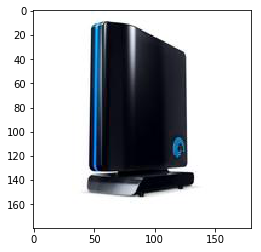

In [88]:
product = db.find_one({'_id': int(3145588)})
assert product is not None
# print(product['category_id'])
img = _img_from_bytes(product['imgs'][0]['picture'])
plt.imshow(img)
plt.show()

In [89]:
olddf = pd.read_csv('../submit/image_level_GMEAN.csv')

In [116]:
ids = set(list(df['_id']))
len(ids)

631963

In [121]:
df.head()

,_id,category_id
0,49,1000011448
1,94,1000004079
2,110,1000010653
3,115,1000002786
4,136,1000014516


In [120]:
olddf.head(10)

,_id,category_id
0,14,1000010653
1,49,1000011448
2,85,1000014276
3,86,1000002805
4,93,1000010653
5,94,1000004079
6,96,1000010110
7,110,1000010653
8,115,1000002786
9,136,1000014516


In [118]:
indexes = []
for i in tqdm(range(olddf.shape[0])):
    if olddf['_id'].iloc[i] in ids:
        indexes.append(i)


 32%|███▏      | 557048/1768182 [00:09<00:20, 57869.71it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/ikibardin/anaconda3/envs/python3.5/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ikibardin/anaconda3/envs/python3.5/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ikibardin/anaconda3/envs/python3.5/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration
100%|██████████| 1768182/1768182 [00:29<00:00, 59184.31it/s]


In [122]:
print(len(indexes), df.shape)

631963 (631963, 2)


In [125]:
(np.array(olddf.iloc[indexes].category_id) != np.array(df.category_id)).sum()

627878

In [137]:
(np.array(olddf.iloc[indexes]._id) == np.array(df._id)).sum()

88

In [142]:
olddf.iloc[indexes].sort_values(by='_id')[80 : 100]

,_id,category_id
291,1187,1000010170
302,1197,1000001752
310,1209,1000010667
283,1258,1000010667
467666,1290,1000012965
288,1300,1000001725
467671,1318,1000004079
290,1327,1000010026
467673,1328,1000003945
451564,1364,1000003983


In [143]:
old_sorted = olddf.iloc[indexes].sort_values(by='_id')
df_sorted = df.sort_values(by='_id')

In [150]:
assert (np.array(df_sorted['_id']) == np.array(old_sorted['_id'])).all()
(np.array(df_sorted['category_id']) != np.array(old_sorted['category_id'])).sum()

44882

In [154]:
final = pd.concat([olddf.drop(indexes), df_sorted], ignore_index=True)

In [159]:
final_sorted = final.sort_values(by='_id')

In [160]:
final_sorted.head()

,_id,category_id
20,10,1000005605
0,14,1000010653
26,21,1000010653
28,24,1000002373
1136219,27,1000022508


In [163]:
olddf_sorted = olddf.sort_values(by='_id')

In [165]:
assert (np.array(final_sorted['_id']) == np.array(olddf_sorted['_id'])).all()
(np.array(final_sorted['category_id']) != np.array(olddf_sorted['category_id'])).sum()

44882

In [201]:
final_sorted[98145 : 98149]

,_id,category_id
786974,982813,1000010608
786975,982824,1000005956
1175279,982825,1000001141
786976,982836,1000005910


In [202]:
olddf_sorted[98145 : 98149]

,_id,category_id
1226541,982813,1000010608
1226542,982824,1000005956
1226543,982825,1000000874
1226544,982836,1000005910


In [175]:
(np.array(final_sorted['category_id']) != np.array(olddf_sorted['category_id'])).argmax()

32

In [200]:
np.argwhere((np.array(final_sorted['category_id']) != np.array(olddf_sorted['category_id'])) == np.amax((np.array(final_sorted['category_id']) != np.array(olddf_sorted['category_id']))))[2050:2055]

array([[98063],
       [98071],
       [98091],
       [98147],
       [98251]])

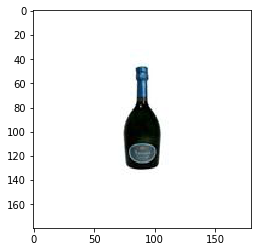

In [208]:
product = db.find_one({'_id': int(982825)})
assert product is not None
# print(product['category_id'])
img = _img_from_bytes(product['imgs'][2]['picture'])
plt.imshow(img)
plt.show()

In [212]:
final_sorted.to_csv('../submit/ANTIHYPE.csv', index=False)

1000003468


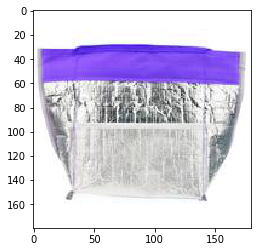

In [53]:
dbtrain = client.cdiscount['train']

product = dbtrain.find_one({'_id': int(1621487)})
assert product is not None
print(product['category_id'])
img = _img_from_bytes(product['imgs'][3]['picture'])
plt.imshow(img)
plt.show()

In [20]:
hashes['01496900222c5739e87e50089b3dec49']

(1621487, 3, 1000003468)

In [35]:
hashes['d5fac557748e89e45df74e1b0351ac54']

(16218454, 1, 1000010057)

1000010057


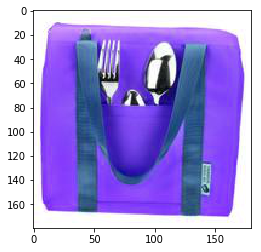

In [54]:
product = dbtrain.find_one({'_id': int(16218454)})
assert product is not None
print(product['category_id'])
img = _img_from_bytes(product['imgs'][0]['picture'])
plt.imshow(img)
plt.show()

count  16643


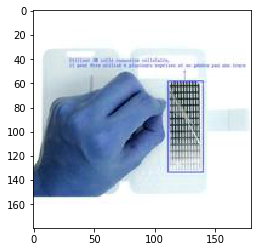

count  16563


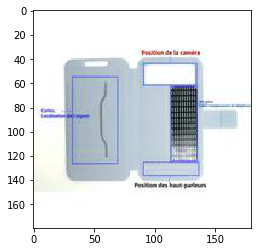

count  16480


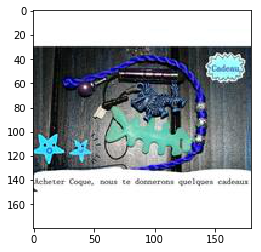

count  15013


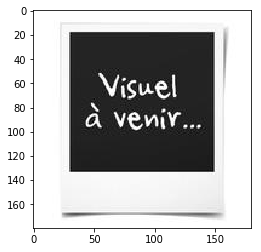

count  13278


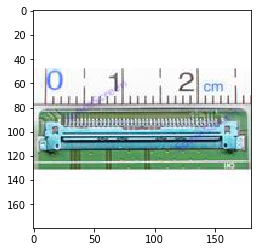

count  13197


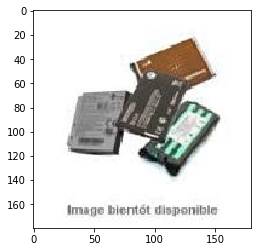

count  10404


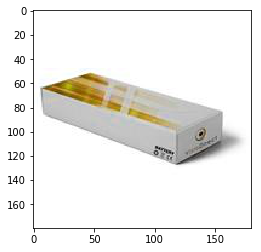

count  9862


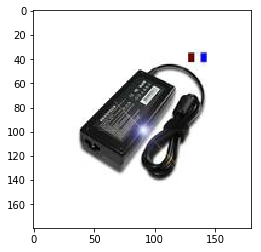

count  9836


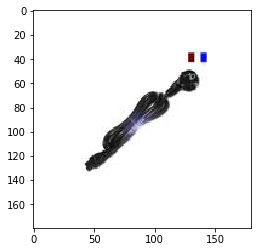

count  9836


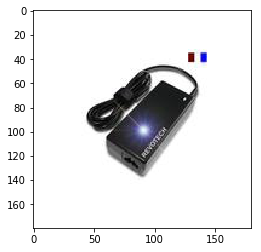

In [27]:
for hash_, count in listed[:10]:
    print("count {} | unique", count)
    product_id, image_number, cat = train[hash_]
    product_id = int(product_id)
    image_number = int(image_number)
    product = db.find_one({'_id': product_id})
    assert product is not None
    img = _img_from_bytes(product['imgs'][image_number]['picture'])
    plt.imshow(img)
    plt.show()

In [61]:
z = x.items()
z

[(1, 2), (3, 5)]

In [62]:
z.sort(key=lambda x : x[1], reverse=True)
z

[(3, 5), (1, 2)]